Dataset saved as 'ab_test_dataset.csv'


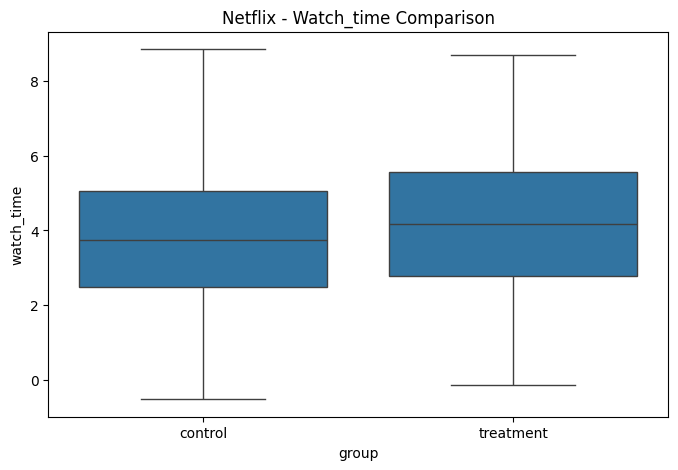

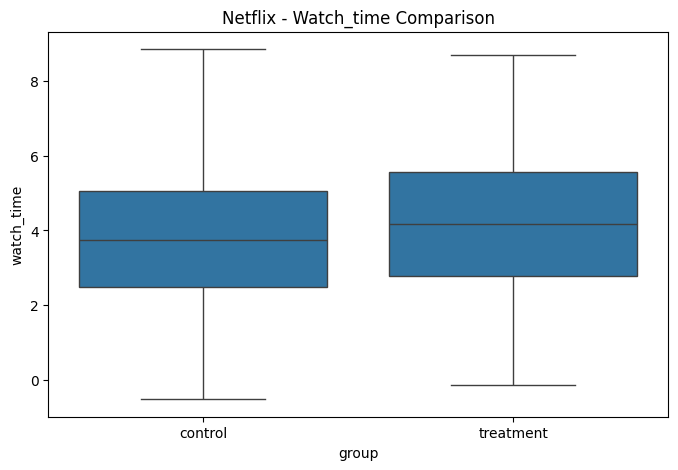

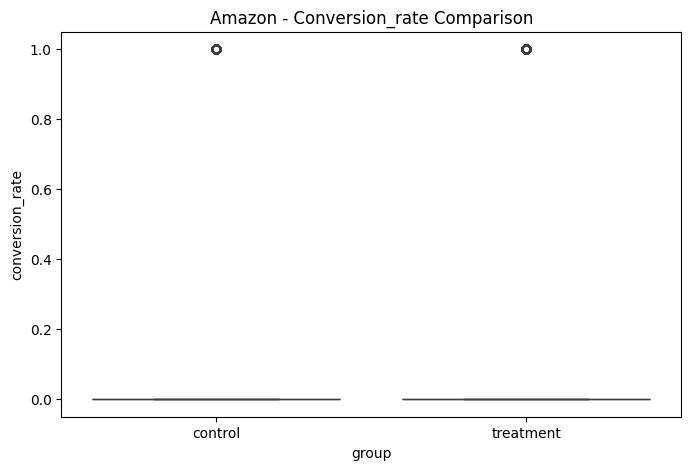

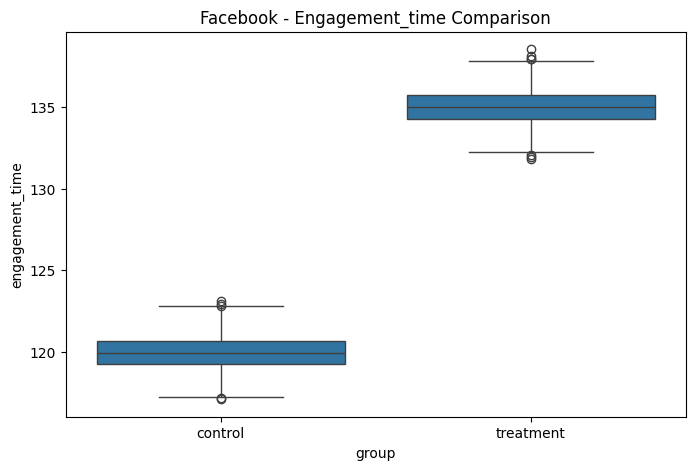

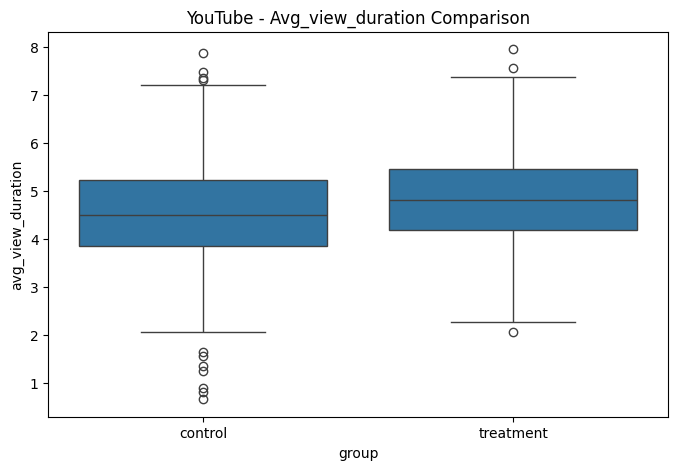

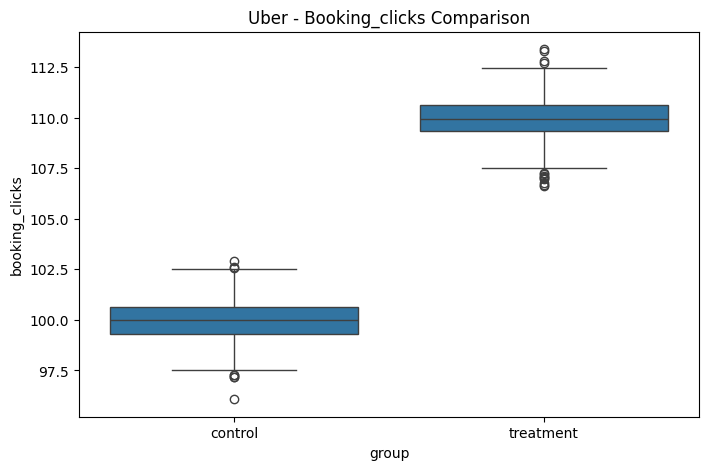

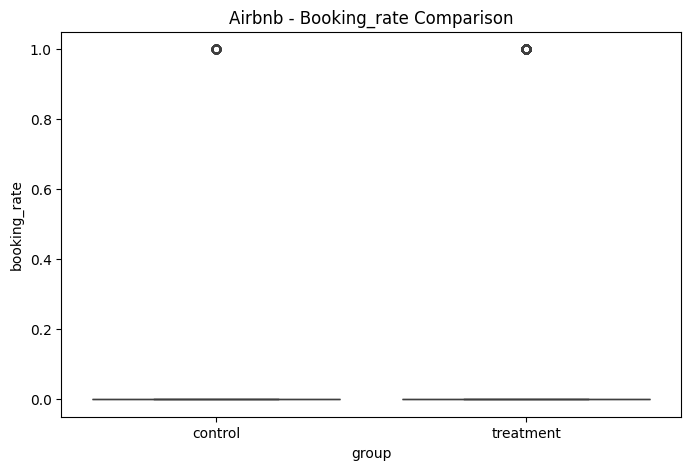

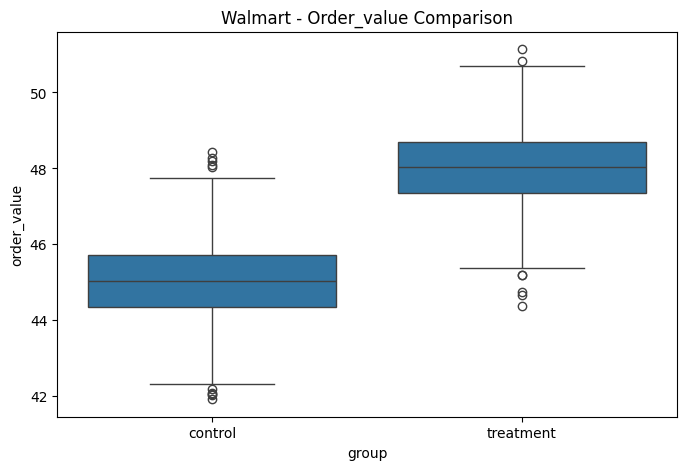

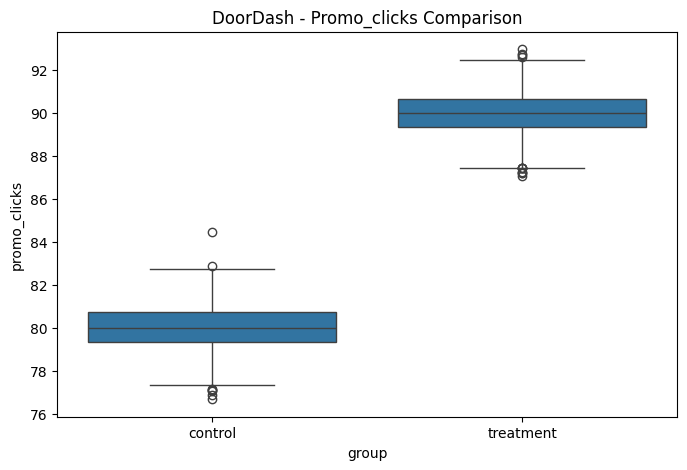

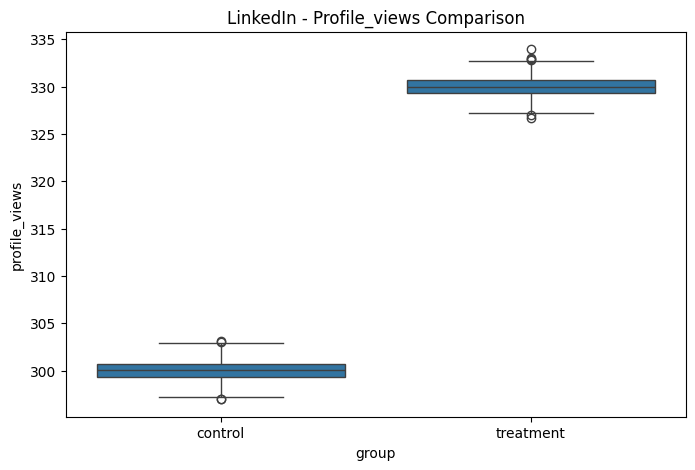

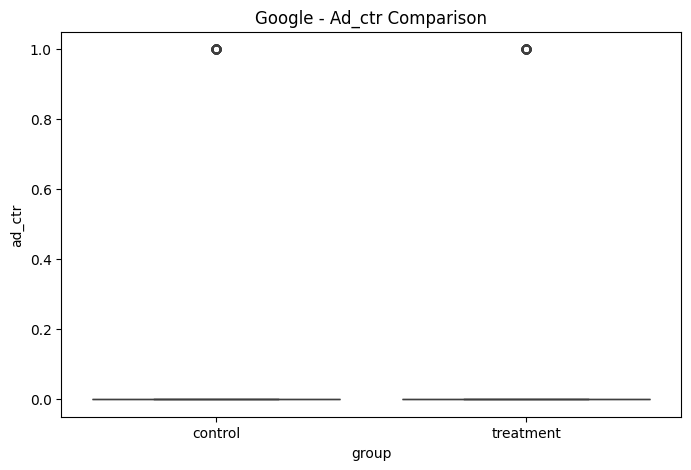


A/B Test Summary:

                               t_stat  p_value  lift_percent  control_mean  \
Netflix - watch_time           7.8750   0.0000       10.9891        3.7626   
Netflix - session_count        7.8750   0.0000       10.9891        3.7626   
Amazon - conversion_rate       2.0201   0.0507       25.6198        0.1210   
Facebook - engagement_time   322.5360   0.0000       12.5096      119.9662   
YouTube - avg_view_duration    6.3279   0.0000        6.2628        4.5284   
Uber - booking_clicks        230.0535   0.0000        9.9950       99.9762   
Airbnb - booking_rate          3.8112   0.0002       62.0690        0.0870   
Walmart - order_value         65.5708   0.0000        6.6200       45.0386   
DoorDash - promo_clicks      222.8007   0.0000       12.4944       80.0206   
LinkedIn - profile_views     666.2520   0.0000        9.9834      300.0346   
Google - ad_ctr               -0.9143   0.4058      -13.0952        0.0840   

                             treatment_mean

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, norm, chi2_contingency  # now includes chi2_contingency
from statsmodels.stats.power import TTestIndPower


# Step 1: Simulate A/B Test Data
np.random.seed(42)

companies = [
    {'name': 'Netflix', 'metrics': {'watch_time': (5.0, 5.5), 'session_count': (2.5, 2.8)}},
    {'name': 'Amazon', 'metrics': {'conversion_rate': (0.12, 0.15)}},
    {'name': 'Facebook', 'metrics': {'engagement_time': (120, 135)}},
    {'name': 'YouTube', 'metrics': {'avg_view_duration': (4.5, 4.8)}},
    {'name': 'Uber', 'metrics': {'booking_clicks': (100, 110)}},
    {'name': 'Airbnb', 'metrics': {'booking_rate': (0.10, 0.13)}},
    {'name': 'Walmart', 'metrics': {'order_value': (45, 48)}},
    {'name': 'DoorDash', 'metrics': {'promo_clicks': (80, 90)}},
    {'name': 'LinkedIn', 'metrics': {'profile_views': (300, 330)}},
    {'name': 'Google', 'metrics': {'ad_ctr': (0.08, 0.09)}}
]

# Define binary metrics for special treatment
def is_binary_metric(metric):
    return 'rate' in metric or 'ctr' in metric or 'conversion' in metric

n = 1000

data = []
for company in companies:
    for metric, (control_mean, treatment_mean) in company['metrics'].items():
        if is_binary_metric(metric):
            control = np.random.binomial(1, control_mean, n)
            treatment = np.random.binomial(1, treatment_mean, n)
        else:
            control = np.random.normal(loc=control_mean, scale=1, size=n)
            treatment = np.random.normal(loc=treatment_mean, scale=1, size=n)

        df_temp = pd.DataFrame({
            'company': company['name'],
            'metric': metric,
            'group': ['control'] * n + ['treatment'] * n,
            'value': np.concatenate([control, treatment])
        })
        data.append(df_temp)

ab_test_data = pd.concat(data, ignore_index=True)

# Save dataset as CSV for reuse in Colab
ab_test_data.to_csv("ab_test_dataset.csv", index=False)
print("Dataset saved as 'ab_test_dataset.csv'")

# Step 2: Analysis Function
def ab_test_analysis(df, company_name, metric_name):
    result = {}
    company_data = df[df['company'] == company_name]
    metric = company_data['metric'].iloc[0]

    control = company_data[company_data['group'] == 'control']['value']
    treatment = company_data[company_data['group'] == 'treatment']['value']

    # Visualization
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='group', y='value', data=company_data)
    plt.title(f'{company_name} - {metric.capitalize()} Comparison')
    plt.ylabel(metric)
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.boxplot(x='group', y='value', data=company_data)
    plt.title(f'{company_name} - {metric_name} Comparison')
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.savefig("plot.png")
    plt.close()

    # T-test
    t_stat, p_value = ttest_ind(treatment, control)
    result['t_stat'] = t_stat
    result['p_value'] = p_value

    # Lift
    control_mean = control.mean()
    treatment_mean = treatment.mean()
    lift = ((treatment_mean - control_mean) / control_mean) * 100
    result['lift_percent'] = lift
    result['control_mean'] = control_mean
    result['treatment_mean'] = treatment_mean

    # Power Analysis
    pooled_std = company_data['value'].std()
    effect_size = (treatment_mean - control_mean) / pooled_std
    analysis = TTestIndPower()
    sample_size = analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05)
    result['required_sample_size'] = sample_size

    # Confidence Interval
    ci_low, ci_high = norm.interval(0.95, loc=treatment_mean, scale=treatment.std()/np.sqrt(len(treatment)))
    result['confidence_interval'] = (ci_low, ci_high)

    # Binary metric detection
    binary = is_binary_metric(metric_name)

    if binary:
        # Chi-square test
        contingency = pd.crosstab(company_data['group'], company_data['value'])
        chi2, p_value, _, _ = chi2_contingency(contingency)
        control_mean = control.mean()
        treatment_mean = treatment.mean()
        lift = ((treatment_mean - control_mean) / control_mean) * 100
        result['test'] = 'Chi-square'
        result['chi2_stat'] = chi2
        result['p_value'] = p_value
        result['lift_percent'] = lift
        result['control_mean'] = control_mean
        result['treatment_mean'] = treatment_mean
        result['required_sample_size'] = 'N/A for chi-square'
        result['confidence_interval'] = 'N/A for chi-square'

    else:
        # T-test
        t_stat, p_value = ttest_ind(treatment, control)
        control_mean = control.mean()
        treatment_mean = treatment.mean()
        lift = ((treatment_mean - control_mean) / control_mean) * 100
        pooled_std = company_data['value'].std()
        effect_size = (treatment_mean - control_mean) / pooled_std
        analysis = TTestIndPower()
        sample_size = analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05)
        ci_low, ci_high = norm.interval(0.95, loc=treatment_mean, scale=treatment.std()/np.sqrt(len(treatment)))
        result['test'] = 'T-test'
        result['t_stat'] = t_stat
        result['p_value'] = p_value
        result['lift_percent'] = lift
        result['control_mean'] = control_mean
        result['treatment_mean'] = treatment_mean
        result['required_sample_size'] = sample_size
        result['confidence_interval'] = (ci_low, ci_high)

    # Business Decision
    decision = "LAUNCH" if p_value < 0.05 else "DO NOT LAUNCH"
    result['business_decision'] = decision

    return result

# Step 3: Run Analysis for All Companies
all_results = {}
for company in ab_test_data['company'].unique():
    metrics = ab_test_data[ab_test_data['company'] == company]['metric'].unique()
    for metric in metrics:
        key = f"{company} - {metric}"
        all_results[key] = ab_test_analysis(ab_test_data, company, metric)

# Step 4: Summary Table
summary_df = pd.DataFrame.from_dict(all_results, orient='index')
print("\nA/B Test Summary:\n")
print(summary_df.round(4))

